In [1]:
from collections import defaultdict
from time import sleep

import ipywidgets as ipyw
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm

import rcimport
import rankcentrality as rank
from rankcentrality import siamese

## Process Images

We want to pass the images through imagenet and see if there is any signal.

In [2]:
img_base_path = "data/placepulse/"
try:
    # raise FileNotFoundError("Force Reload")
    X = np.load("../output/ppimgnet.npz")["X"]
except FileNotFoundError:
    import tensorflow as tf
    import tensorflow_hub as hub

    module = hub.load(
        "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4"
    )

    img_files = [f"{img_base_path}{i}.jpg" for i in range(100)]
    img_raw = [tf.io.read_file(f) for f in img_files]
    img_tensor = [tf.image.decode_image(img).numpy() for img in img_raw]

    X = module((np.array(img_tensor) / 255.0).astype(np.float32)).numpy()
    np.savez_compressed("../output/ppimgnet.npz", X=X)

In [3]:
p = PCA(5)

In [4]:
X_pca = p.fit_transform(X)

In [5]:
spectral_clustering = SpectralClustering(20)
clusts = spectral_clustering.fit_predict(X_pca)

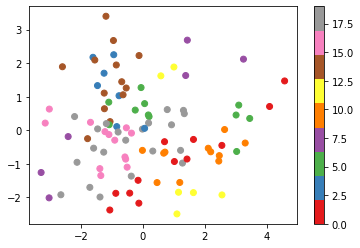

In [6]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusts, cmap="Set1")
plt.colorbar()

In [7]:
def show_clust(clust_ind):
    for img_ind in np.nonzero(clusts == clust_ind)[0]:
        display.display(
            ipyw.Image(
                value=f"{img_base_path}{img_ind}.jpg".encode(),
                format="url",
                width=300,
            )
        )

In [8]:
out = ipyw.interactive(
    show_clust, clust_ind=ipyw.BoundedIntText(min=0, max=clusts.max(), value=0)
)
out

Image(value=b'data/placepulse/38.jpg', format='url', width='300')

Image(value=b'data/placepulse/47.jpg', format='url', width='300')

Image(value=b'data/placepulse/48.jpg', format='url', width='300')

Image(value=b'data/placepulse/73.jpg', format='url', width='300')

Image(value=b'data/placepulse/74.jpg', format='url', width='300')

In [9]:
reind = np.argsort(clusts)

In [10]:
D = rank.RankCentrality.get_diffusion_matrix(
    None, X, 0.125, 0, metric="cosine"
)

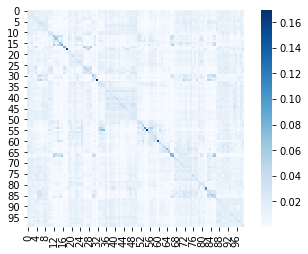

In [11]:
g = sns.heatmap(D[reind, :][:, reind], square=True, cmap="Blues")

There seem to be some real clusters and the images within each cluster do look similar.

## Load Comparisons

In [12]:
df_comparisons = pd.read_pickle("data/placepulse/comparisons.pkl")

In [13]:
df_comparisons.head(5)

,alg_label,available,left,right,timestamp,winner
0,Random,1,78,81,2017-03-01 01:33:52.076000,81
1,Random,1,94,1,2017-03-01 01:34:08.828000,1
2,Random,1,96,28,2017-03-01 01:34:23.624000,96
3,QuicksortTree_0,1,78,76,2017-03-01 01:34:43.164000,76
4,QuicksortTree_0,1,78,75,2017-03-01 01:35:00.620000,75


In [14]:
comps = df_comparisons[["left", "right"]].to_numpy()
comps.sort(axis=1)  # (a, b) ~ (b, a)
ids, counts = np.unique(comps @ [100, 1], return_counts=True)

In [15]:
n_points = np.unique(comps).size
# check that items are 0, ..., n-1
assert np.array_equal(np.unique(comps), np.arange(n_points))

In [16]:
counts_flat = np.zeros((n_points * (n_points - 1)) // 2, dtype=int)
counts_flat[: len(counts)] = counts

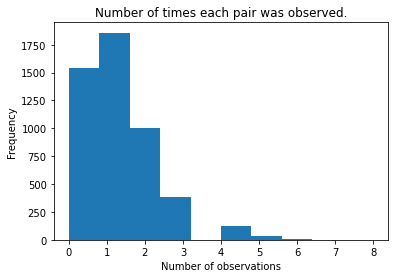

In [17]:
plt.hist(counts_flat)
plt.title("Number of times each pair was observed.")
plt.xlabel("Number of observations")
plt.ylabel("Frequency")
plt.show()

In [18]:
all_comps = df_comparisons[["left", "right"]].to_numpy()
all_comp_results = (
    (df_comparisons["winner"] == df_comparisons["right"])
    .to_numpy()
    .astype(int)
)
assert (
    (df_comparisons["winner"] == df_comparisons["right"])
    ^ (df_comparisons["winner"] == df_comparisons["left"])
).all()

In [19]:
n_train = 1280
n_val = 2000
n_test = len(all_comps) - n_train - n_val
print(f"{n_test} test observations")

2470 test observations


In [20]:
partition = np.concatenate(
    (np.repeat(0, n_train), np.repeat(1, n_val), np.repeat(2, n_test))
)
np.random.seed(0)
np.random.shuffle(partition)
np.unique(partition, return_counts=True)

train_mask = partition == 0
val_mask = partition == 1
test_mask = partition == 2

train_comps = all_comps[train_mask]
train_comp_results = all_comp_results[train_mask]

val_comps = all_comps[val_mask]
val_comp_results = all_comp_results[val_mask]

test_comps = all_comps[test_mask]
test_comp_results = all_comp_results[test_mask]

## Vary Widths

In [21]:
num_draws = 10
# D_reg = d_lam(n_points, 1 / (10 * n_points))
widths_arr = np.linspace(0.01, 0.1, 20)
scores_hat_diffrc = defaultdict(lambda: [[] for _ in widths_arr])
for n_comps in tqdm([(n_points // 10) * 2 ** i for i in range(1, 8)]):
    for _ in range(num_draws):
        train_inds = np.random.choice(n_train, n_comps, replace=False)
        comps, comp_results = (
            train_comps[train_inds],
            train_comp_results[train_inds],
        )
        rc = rank.RankCentrality(n_points, comps, comp_results)
        for width_ind, width in enumerate(widths_arr):
            scores_hat_diffrc[f"{n_comps} comparisons"][width_ind].append(
                rc.run_diffused_decayed(
                    X, width, metric="cosine", lam=np.exp(-3)
                )
            )

100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


In [22]:
metrics = rank.stats.compute_experiment_test_errors(
    scores_hat_diffrc, val_comps, val_comp_results, len(widths_arr), num_draws
)

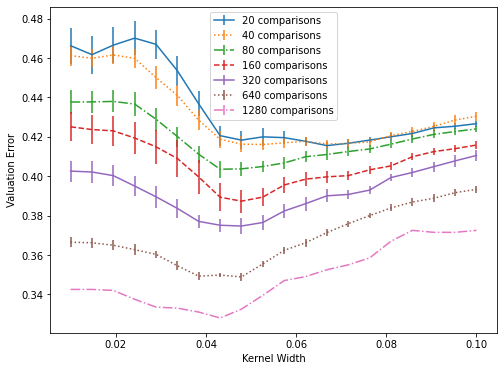

In [23]:
f, ax = rank.stats.plot_experiment_metrics(
    metrics,
    num_comps_list=widths_arr,
    loss="Valuation Error",
    num_comps_label="Kernel Width",
)
ax.set_xscale("linear")
f.set_figheight(6)
f.set_figwidth(8)

In [24]:
diff_df = rank.stats.experiment_metrics_to_dataframe(metrics, widths_arr)
diff_df.index.name = "widths"

In [25]:
diff_df.to_csv(f"../output/placepulse_variablewidths.csv")

## Compare Algorithms

In [26]:
n_comps_arr = np.array((n_points // 10) * (2 ** np.arange(8)))
assert (
    n_comps_arr.max() <= n_train
), f"We don't have {n_comps_arr.max()} comparisons in the test dataset"

In [27]:
kernel_width = 0.043

In [28]:
np.random.seed(1234)  # to make results reproducible for discussions

In [29]:
num_draws = 20
what_dict = defaultdict(lambda: [[] for _ in n_comps_arr])
for m_ind, n_comps in enumerate(tqdm(n_comps_arr, desc="num_comps")):
    for _ in range(
        num_draws
    ):  # tqdm(range(num_draws), desc="draws", leave=False):
        sleep(0.00001)  # odd ARPACK errors without this...
        train_inds = np.random.choice(n_train, n_comps, replace=False)
        comps = train_comps[train_inds]
        comp_results = train_comp_results[train_inds]
        rc = rank.RankCentrality(n_points, comps, comp_results)
        what_dict["regRC"][m_ind].append(rc.run_regularized_decayed(5))
        what_dict[f"diffRC"][m_ind].append(
            rc.run_diffused_decayed(X, kernel_width, metric="cosine")
        )
        btl = rank.BTLMLE(n_points, comps, comp_results)
        what_dict["BTL-MLE-reg"][m_ind].append(btl.run())
        ranksvm = rank.RankSVM(n_points, comps, comp_results, X)
        what_dict["RankSVM"][m_ind].append(ranksvm.run())
        ranksvm_rf = rank.RankSVM(n_points, comps, comp_results, X)
        what_dict["RF-RankSVM"][m_ind].append(ranksvm_rf.run_random_features())
        snn = siamese.SiameseNetRank(n_points, comps, comp_results, X)
        what_dict["SNN"][m_ind].append(snn.run())

num_comps: 100%|██████████| 8/8 [06:37<00:00, 49.73s/it]


In [30]:
metrics = rank.stats.compute_experiment_test_errors(
    what_dict, test_comps, test_comp_results, len(n_comps_arr), num_draws
)

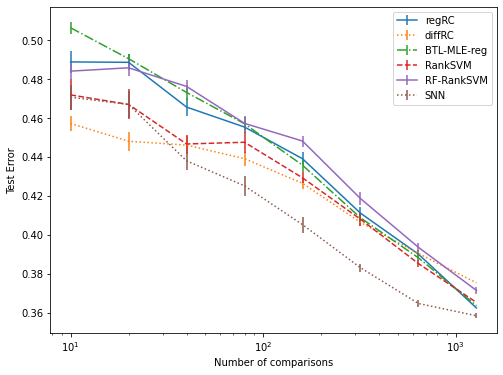

In [31]:
f, ax = rank.stats.plot_experiment_metrics(metrics, n_comps_arr, "Test Error")
f.set_figheight(6)
f.set_figwidth(8)

In [32]:
df = rank.stats.experiment_metrics_to_dataframe(metrics, n_comps_arr)

In [33]:
df.to_csv(f"../output/placepulse_width{kernel_width}.csv")